# GISAID SAMPLES

In [ ]:
import pandas as pd
# import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
# import altair as alt
from enum import Enum, auto
import seaborn as sns

Define the utilities for how to handle dates

In [2]:
class DateResolution(Enum):
    DAY = auto()
    MONTH = auto()
    YEAR = auto()
    MISSING = auto()

def determine_resolution(date_str) -> DateResolution:
    """
    Determine the resolution of the given date string.

    Args:
    - date_str: A string representation of a date

    Returns:
    - A DateResolution enum value indicating the resolution of the date
    """
    if pd.isna(date_str) or date_str == "?":
        return DateResolution.MISSING
    elif "-" in date_str:
        parts = date_str.split("-")
        if len(parts) == 3:
            return DateResolution.DAY
        elif len(parts) == 2:
            return DateResolution.MONTH
    elif date_str.isdigit():  # Only year is provided
        return DateResolution.YEAR

    return DateResolution.MISSING  # default

def robust_fromisoformat(date_string: str) -> pd.Timestamp:
    """
    Convert a string into a datetime object. This function is designed to handle common variations in date formatting.

    Args:
        date_string (str): A date in string format.

    Returns:
        pd.Timestamp: Corresponding datetime object.

    Notes:
    - If the string is "?", it returns a NaT (Not a Time).
    - If the string format represents a month only (e.g., "2023-03"), it returns the approximate midpoint of the month (e.g., "2023-03-15").
    - If the string format represents a year only (e.g., "2023"), it returns the approximate midpoint of the year (e.g., "2023-06-01").
    """

    if pd.isna(date_string) or date_string == "?":
       return pd.NaT
    elif "-" not in date_string and len(date_string) == 4:  # Only a year is provided
       return datetime.fromisoformat(f"{date_string}-06-01")
    elif date_string.count("-") == 1:  # Only year and month are provided
        mid_date = f"{date_string}-15"
        if len(mid_date) == 10:
            return datetime.fromisoformat(mid_date)
        else:
            padded_date_string = '-'.join(i.zfill(2) for i in mid_date.split('-'))
            return datetime.fromisoformat(padded_date_string)
    elif len(date_string) != 10:
        padded_date_string = '-'.join(i.zfill(2) for i in date_string.split('-'))
        return datetime.fromisoformat(padded_date_string)
    else:
        return datetime.fromisoformat(date_string)

### Inputs

In [ ]:
# Define variables provided by snakemake workflow
# META = "../../../bigger-tree/2023-10-02/gisaidAndPublic.2023-10-01.metadata.tsv.gz"
META = snakemake.input["meta"]

DATETIME_CUTOFF = snakemake.params["datetime_cutoff"]
SUBSET_FRAC = snakemake.params["subset_frac"]
# INVALID_DATE_RES = ["MISSING", "MONTH", "YEAR"]
# MIN_DATE = "2019-12-01"
INVALID_DATE_RES = snakemake.params.qc_filter_options["invalid_date_resolutions"]
MIN_DATE = snakemake.params.qc_filter_options["min_date"]

# VALID_HOSTS = ["Human", "Homo sapiens"]
# MISSING_HOST_IS_VALID = True
VALID_HOSTS = snakemake.params.qc_filter_options["valid_hosts"]
MISSING_HOST_IS_VALID = snakemake.params.qc_filter_options["missing_host_is_valid"]

# MIN_GENOME_LENGTH = 28000
# MAX_GENOME_LENGTH = 32000
MIN_GENOME_LENGTH = snakemake.params.qc_filter_options["min_genome_length"]
MAX_GENOME_LENGTH = snakemake.params.qc_filter_options["max_genome_length"]

# OUTPUT
# FILTERED_META_OUT = "filtered_metadata.tsv.gz"
# INVALID_STRAINS_OUT = "invalid_strains.txt"
FILTERED_META_OUT = snakemake.output["filtered_metadata"]
INVALID_STRAINS_OUT = snakemake.log["invalid_strains"]


First, we'll load in the metadata

In [4]:
meta_df = pd.read_csv(
    META, 
    compression="gzip", 
    sep="\t",
    low_memory=False
)

# Early Subsetting

Apply random subsetting based on subset_frac parameter to reduce dataset size before any processing.

In [ ]:
print(f"Original dataset size: {len(meta_df)}")

# Apply random subsetting based on subset_frac early
if SUBSET_FRAC < 1.0:
    subset_size = int(len(meta_df) * SUBSET_FRAC)
    meta_df = meta_df.sample(n=subset_size, random_state=42)
    print(f"After random subsetting: {len(meta_df)}")

Next, infer the date resolution of the date.

In [ ]:
meta_df["date_resolution"] = meta_df["date"].apply(determine_resolution)
meta_df["date_resolution_str"] = meta_df["date_resolution"].apply(lambda x: x.name)
meta_df.drop(columns=["date_resolution"], inplace=True)

# Convert dates
meta_df["date"] = meta_df["date"].apply(robust_fromisoformat)

In [ ]:

# Apply datetime cutoff filtering right after date conversion
datetime_cutoff = datetime.fromisoformat(DATETIME_CUTOFF)
valid_dates = ~pd.isna(meta_df['date'])
date_filtered_df = meta_df[valid_dates & (meta_df['date'] <= datetime_cutoff)]

# Keep track of dropped samples due to date cutoff
dropped_by_cutoff = len(meta_df) - len(date_filtered_df)
print(f"Dropped {dropped_by_cutoff} samples due to date cutoff or invalid dates")

# Replace the original dataframe with the filtered one
meta_df = date_filtered_df
print(f"Dataset size after date cutoff filtering: {len(meta_df)}")

In [ ]:
meta_df.head()

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher,date_resolution_str
0,100002|LR824035.1|2020-03-05,LR824035.1,2020-03-05,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
1,100003|LR824038.1|2020-03-04,LR824038.1,2020-03-04,Switzerland,NaN,NaN,29903.0,20B,B.1.1,20B,B.1.1,DAY
2,100004|LR824040.1|2020-03-06,LR824040.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
3,100005|LR824037.1|2020-03-06,LR824037.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
4,100006|LR824041.1|2020-03-06,LR824041.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY


In [8]:
meta_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16236388 entries, 0 to 16236387
Data columns (total 12 columns):
 #   Column                  Non-Null Count     Dtype         
---  ------                  --------------     -----         
 0   strain                  16236388 non-null  object        
 1   genbank_accession       7506596 non-null   object        
 2   date                    16235543 non-null  datetime64[ns]
 3   country                 16231114 non-null  object        
 4   host                    140952 non-null    object        
 5   completeness            130516 non-null    object        
 6   length                  15499702 non-null  float64       
 7   Nextstrain_clade        16234056 non-null  object        
 8   pangolin_lineage        16236387 non-null  object        
 9   Nextstrain_clade_usher  16236388 non-null  object        
 10  pango_lineage_usher     16236388 non-null  object        
 11  date_resolution_str     16236388 non-null  object        
dty

In [9]:
meta_df["date_resolution_str"].value_counts()

date_resolution_str
DAY        15983833
MONTH        196929
YEAR          54781
MISSING         845
Name: count, dtype: int64

In [10]:
meta_df.sort_values("date").head(10)

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher,date_resolution_str
8661283,Mexico/SON-InDRE_FB17149_S3230/2021|EPI_ISL_26...,NaN,1973-04-15,Mexico,NaN,NaN,29822.0,20J,P.1.15,"20J (Gamma,V3)",P.1.15,DAY
8669612,Mexico/YUC-InDRE_FB17098_S3215/2021|EPI_ISL_26...,NaN,1993-04-17,Mexico,NaN,NaN,29823.0,20J,P.1.17,"20J (Gamma,V3)",P.1.17,DAY
1522654,CzechRepublic/NRL_6465_21/2021|EPI_ISL_2324899...,NaN,2016-04-16,Czech Republic,NaN,NaN,29832.0,20I,B.1.1.7,"20I (Alpha,V1)",B.1.1.7,DAY
760383,CHN/2019/2019|C_AA011730.1|2019,NaN,2019-06-01,China,Homo sapiens,Complete,29714.0,19B,A,19B,A,YEAR
760384,CHN/2019/2019|C_AA011731.1|2019,NaN,2019-06-01,China,Homo sapiens,Complete,29690.0,19B,A,19B,A,YEAR
760385,CHN/2019/2019|C_AA011732.1|2019,NaN,2019-06-01,China,Homo sapiens,Complete,29714.0,19A,A,19A,B,YEAR
760386,CHN/2019/2019|C_AA011733.1|2019,NaN,2019-06-01,China,Homo sapiens,Complete,29714.0,20A,B.1,20A,B.1,YEAR
16209554,Wuhan-Hu-1|MN908947.3|2019-12,MN908947.3,2019-12-15,China,NaN,NaN,29903.0,19A,B,19A,B,MONTH
16209761,Wuhan/IPBCAMS-WH-01/2019|MT019529.1|2019-12-23,MT019529.1,2019-12-23,China,NaN,NaN,29899.0,19A,B,19A,B,DAY
16209760,Wuhan/IPBCAMS-WH-01/2019|GWHABKF00000001|2019-...,NaN,2019-12-24,China,Homo sapiens,Complete,29899.0,19A,B,19A,B,DAY


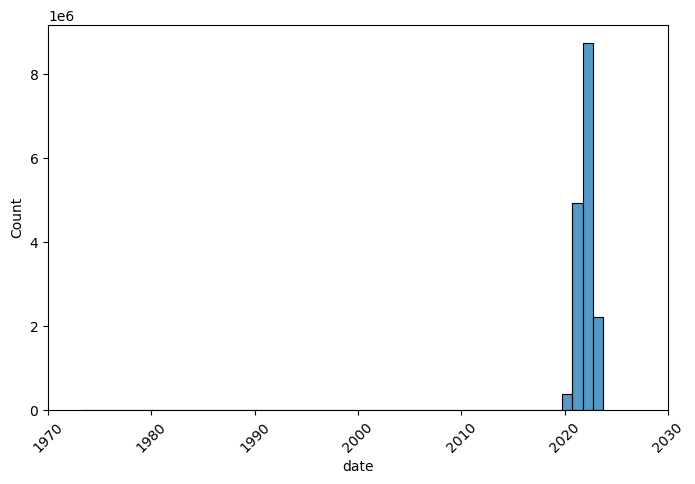

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(meta_df["date"], ax=ax, bins=50)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

<Axes: xlabel='length'>

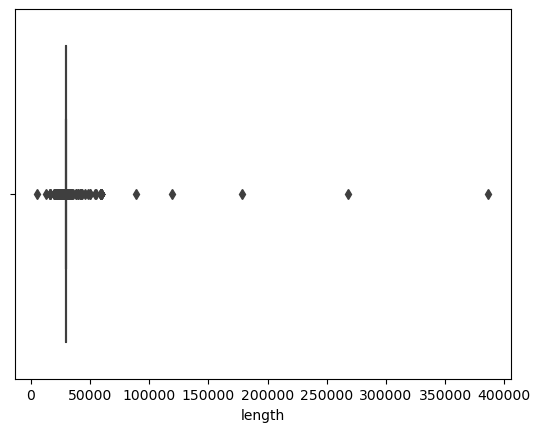

In [12]:
sns.boxplot(x="length", data=meta_df)

# QC Filter #1 - Date Resolution

discarding anything with a missing date, or date before 2019-06-01

In [ ]:
invalid_resolution = meta_df["date_resolution_str"].isin(["MISSING", "MONTH", "YEAR"])
invalid_time = meta_df["date"] < robust_fromisoformat("2019-12-01")
invalid_date = meta_df[invalid_resolution | invalid_time]
qc_1_strain_to_drop = invalid_date["strain"].to_list()
qc_1_idx_to_drop = invalid_date.index.to_list()
print(f"There are {len(qc_1_idx_to_drop)} samples to drop due to invalid date")

There are 252558 samples to drop due to invalid date


In [14]:
meta_df.drop(qc_1_idx_to_drop, inplace=True)

In [15]:
meta_df.sort_values("date").head()

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher,date_resolution_str
16209761,Wuhan/IPBCAMS-WH-01/2019|MT019529.1|2019-12-23,MT019529.1,2019-12-23,China,NaN,NaN,29899.0,19A,B,19A,B,DAY
16209760,Wuhan/IPBCAMS-WH-01/2019|GWHABKF00000001|2019-...,NaN,2019-12-24,China,Homo sapiens,Complete,29899.0,19A,B,19A,B,DAY
15786956,WH01|CNA0007332|2019-12-26,NaN,2019-12-26,China,Homo sapiens,Complete,29866.0,19A,B,19A,B,DAY
16209782,Wuhan/WH04/2020|LR757995.1|2019-12-26,LR757995.1,2019-12-26,China,NaN,NaN,29872.0,19B,A,19B,A,DAY
16209780,Wuhan/WH01/2019|LR757998.1|2019-12-26,LR757998.1,2019-12-26,China,NaN,NaN,29866.0,19A,B,19A,B,DAY


Note that Wuhan/IPBCAMS-WH-01/2019|MT019529.1|2019-12-23 could be a reasonable reference to use with chronumental.

Next, let's take a look at the most recent dates

In [16]:
meta_df.sort_values("date", ascending=False).head()

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher,date_resolution_str
2751432,England/CLIMB-CM7YFQWK/2023|2023-09-27,NaN,2023-09-27,England,NaN,NaN,NaN,23B,HF.1,23B (XBB.1.16),HF.1,DAY
2745117,England/CLIMB-CM7Y81RZ/2023|2023-09-27,NaN,2023-09-27,England,NaN,NaN,NaN,23B,XBB.1.16.6,23B (XBB.1.16),XBB.1.16.6,DAY
2758265,England/CLIMB-CM7YKH98/2023|2023-09-26,NaN,2023-09-26,England,NaN,NaN,NaN,23F,HV.1,23F (EG.5.1),HV.1,DAY
2763578,England/CLIMB-CM7YRSMP/2023|2023-09-25,NaN,2023-09-25,England,NaN,NaN,NaN,23F,HK.3,23F (EG.5.1),HK.3,DAY
2756711,England/CLIMB-CM7YJUQE/2023|2023-09-25,NaN,2023-09-25,England,NaN,NaN,NaN,23C,DV.7.1,23C (CH.1.1),DV.7.1,DAY


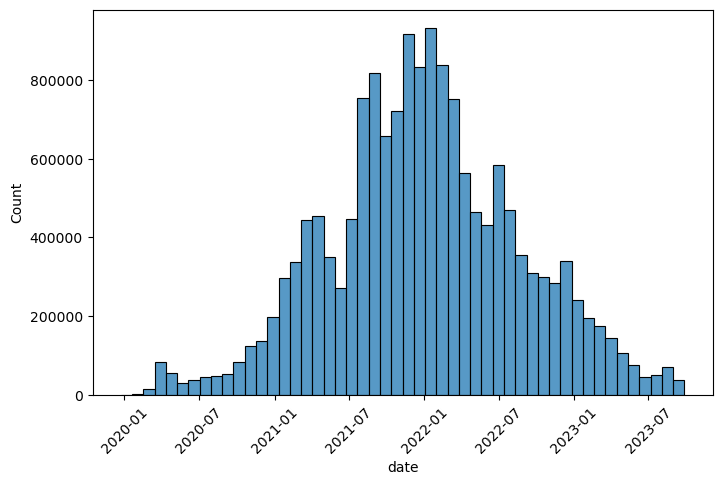

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(meta_df["date"], ax=ax, bins=50)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

# QC Filter #2 - Host

It seems there are some NHP samples in the dataset. We'll discard those.

In [18]:
if "host" in meta_df.columns:
    print(meta_df["host"].value_counts())

host
Human                       91967
Homo sapiens                45421
Mink                          370
Environment                    68
ENV                             7
Panthera tigris jacksoni        6
Felis catus                     3
Panthera leo                    3
unknown                         1
Mus musculus                    1
Name: count, dtype: int64


Obviously, there's a lot of unknown hosts. We'll have to keep the unknowns for now, and discard anything explicitely non-human.

In [19]:
missing_valid = lambda v: not pd.isna(v) if MISSING_HOST_IS_VALID else pd.isna(v)
invalid_host_names = [
    v 
    for v in meta_df['host'].unique() 
    if v not in VALID_HOSTS and missing_valid(v)
]
invalid_host = meta_df[meta_df["host"].isin(invalid_host_names)]
qc_2_strain_to_drop = invalid_host["strain"].to_list()
qc_2_idx_to_drop = invalid_host.index.to_list()
print(f"there are {len(qc_2_idx_to_drop)} invalid hosts")

there are 459 invalid hosts


In [20]:
meta_df.drop(qc_2_idx_to_drop, inplace=True)

# QC Filter #3 - Length

In [21]:
meta_df['length'].describe()

count    1.524679e+07
mean     2.976243e+04
std      1.924449e+02
min      5.675000e+03
25%      2.972300e+04
50%      2.978300e+04
75%      2.985000e+04
max      3.864610e+05
Name: length, dtype: float64

In [22]:
print(f"there are ({sum(meta_df['length'].isnull())}) samples with missing length information")

there are (736579) samples with missing length information


In [23]:
invalid_length = meta_df[~meta_df["length"].between(MIN_GENOME_LENGTH, MAX_GENOME_LENGTH)]
print(f"There are {len(invalid_length)} samples with invalid length attribute")
qc_3_strain_to_drop = invalid_length["strain"].to_list()
qc_3_idx_to_drop = invalid_length.index.to_list()
meta_df.drop(qc_3_idx_to_drop, inplace=True)

There are 739230 samples with invalid length attribute


<Axes: xlabel='length'>

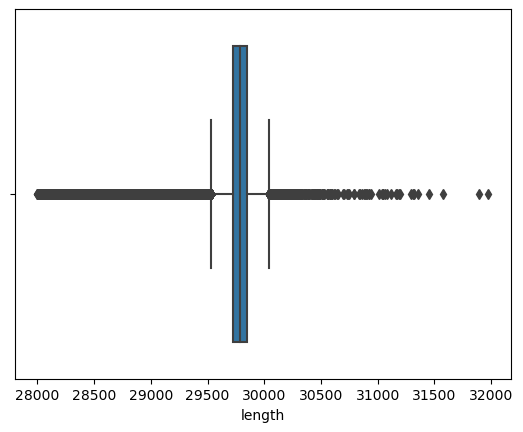

In [24]:
sns.boxplot(x="length", data=meta_df)

## OUTPUTS

In [25]:
meta_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15244141 entries, 0 to 16236386
Data columns (total 12 columns):
 #   Column                  Non-Null Count     Dtype         
---  ------                  --------------     -----         
 0   strain                  15244141 non-null  object        
 1   genbank_accession       7455350 non-null   object        
 2   date                    15244141 non-null  datetime64[ns]
 3   country                 15238928 non-null  object        
 4   host                    137340 non-null    object        
 5   completeness            126904 non-null    object        
 6   length                  15244141 non-null  float64       
 7   Nextstrain_clade        15242357 non-null  object        
 8   pangolin_lineage        15244140 non-null  object        
 9   Nextstrain_clade_usher  15244141 non-null  object        
 10  pango_lineage_usher     15244141 non-null  object        
 11  date_resolution_str     15244141 non-null  object        
dtypes: 

In [26]:
meta_df.head()

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher,date_resolution_str
0,100002|LR824035.1|2020-03-05,LR824035.1,2020-03-05,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
1,100003|LR824038.1|2020-03-04,LR824038.1,2020-03-04,Switzerland,NaN,NaN,29903.0,20B,B.1.1,20B,B.1.1,DAY
2,100004|LR824040.1|2020-03-06,LR824040.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
3,100005|LR824037.1|2020-03-06,LR824037.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY
4,100006|LR824041.1|2020-03-06,LR824041.1,2020-03-06,Switzerland,NaN,NaN,29903.0,20A,B.1,20A,B.1,DAY


In [ ]:
# Show summary statistics of the final dataset
print(f"Date range: {meta_df['date'].min()} to {meta_df['date'].max()}")
print(f"Number of unique hosts: {meta_df['host'].nunique()}")
print(f"Genome length range: {meta_df['length'].min()} to {meta_df['length'].max()}")

In [27]:
meta_df.to_csv(FILTERED_META_OUT, sep="\t", index=False)
with open(INVALID_STRAINS_OUT, "w") as f:
    f.write("\n".join(qc_1_strain_to_drop + qc_2_strain_to_drop + qc_3_strain_to_drop)+"\n")

In [ ]:
# This step was moved earlier in the pipeline
print(f"Final dataset size: {len(meta_df)}")